# **Código**

A continuación se presenta el código generado para extraer las variantes asociadas a los genes implicados en enfermedades mendelianas, así como sus consecuencias. 

In [1]:
%load_ext rpy2.ipython

# **1. Extraer las coordenadas genómicas de los genes implicados en enfermedades mendelianas humanas**

Inicialmente se extraen las variables de filtrado para cada gen asociado a una  enfermedad medeliana: cromosoma donde reside, posición de inicio y posición de fin. Posteriormente se limpian los datos eliminando genes con alguno de estos 3 campos faltantes, se parsean para su posterior uso y se eliminan entradas con datos anormales previamente identificados.

In [2]:
%%R
## Datos de entrada 
data <- read.table("genemap2.txt",sep = "\t",header = FALSE, fill =  TRUE)
## Dimensiones de los datos
dim(data)
## df con las columnas de interés: chr, inicio y fin
df<-data.frame(data[,1], data[,2], data[,3])
head(df,10)
## Dimesiones del df
dim(df)
## Corroborar que los datos estén completos
## Filas con datos faltantes ("") o NA
incomp_rows<-which(rowSums(is.na(df) | df == "") > 0)
## Eliminar esas filas
df<-df[-incomp_rows,]
dim(df)

## Parsear datos
## "chri" a "i"
df[,1]<-sub("chr","",df[,1])
tail(df)

## Eliminar genes que comprendan una región > 1,000,000 nt para pasos posteriores
df<-df[-which(strtoi(df[,3])-strtoi(df[,2])>1000000),]

## Eliminar entradas con datos anormales
df<-df[-3359,]

print(dim(df))

## Datos del gen con mayor número de variantes encontradas
## (ver código completo)
print(data[5290,8])
print(data[5290,11])
print(data[5290,13])

[1] 8551    3
[1] "BRCA2 DNA repair-associated protein"
[1] "ENSG00000139618"
[1] "Fanconi anemia, complementation group D1, 605724 (3), Autosomal recessive; {Glioblastoma 3}, 613029 (3), Autosomal recessive; {Medulloblastoma}, 155255 (3), Autosomal recessive, Somatic mutation, Autosomal dominant; {Prostate cancer}, 176807 (3), Somatic mutation, Autosomal dominant; {Breast-ovarian cancer, familial, 2}, 612555 (3), Autosomal dominant; {Breast cancer, male, susceptibility to}, 114480 (3), Somatic mutation, Autosomal dominant; {Pancreatic cancer 2}, 613347 (3); Wilms tumor, 194070 (3), Somatic mutation, Autosomal dominant"


# **2. Obtener las variantes asociadas a las regiones que cada gen comprende**

Posteriormente se generan solicitudes HTTP para acceder a la información del recurso overlap de Ensembl dada la región genómica de cada gen y la especie *Homo sapiens*. Se extraen las variantes resultantes de cada región provenientes del *dataset* ***clin_assoc***. 
Para aquellas enfermedades monogénicas multicausales que contengan más de una variante patogénica asociada, se toma a cada una de estas variantes como independientes ya que todas poseen relevancia clínica y dado que se busca el número de mutaciones asociadas a enfermedades.

In [ ]:
%%R
## Importar librerías necesarias
library(httr)
library(jsonlite)

## Función para extraer las variantes dada una región genómica
getVariantsInRegion <- function(chr, start, end) {
    ## Región genómica
    region<-paste(chr,":",start,"-",end, sep="")
    ## Buscar variantes en recurso overlap de Ensembl, dada una región y una especie
    server <- "https://rest.ensembl.org/overlap/region/human/"
    ## Buscar variantes en el dataset de clin_assoc
    extension <- "?feature=variation;variant_set=clin_assoc"
    ## Generar solicitud HTTP
    full_url <- paste0(server, region, extension)
    ## Recuperar registros de la búsqueda 
    result <- GET(full_url, content_type("application/json"))
    stop_for_status(result)
    ## Resultados
    fromJSON(toJSON(content(result)))
}



# **3. Extraer variantes SNPs/*indels* patogénicas y con coordenadas genómicas del genoma humano GRCh38**

Una vez que se obtienen todas las variantes asociadas a cada gen, estas se filtran por significancia clínica (solo se retienen las **patogénicas**), por tipo de variante (si son de nucleótido único o *indels*) y por la versión del genoma humano que determina sus coordenadas genómicas (**GRCh38**). 
Se extrae el ID y el tipo de consecuencia de cada una de estas variantes ya que este último determina su tipo de región genómica.

Adicionalmente se obtiene el número de variantes asociadas a cada gen y a cada cromosoma. 

In [ ]:
%%R
conseqs<-vector()
num_var<-vector()
chr_var<-vector()
ids<-vector()
total_vars<-vector()

## Para cada gen
for (i in 1:nrow(df)) {
  ## Extraer variantes asociadas a la región
  vars <- getVariantsInRegion(chr= df[i,1], start=df[i,2], end=df[i,3])
  if (length(vars)>0){
    ## Número total de variantes
    total_vars<-append(total_vars, nrow(vars))
    ## Filtrar variables por sig clínica, versión del genoma humano y tipo SNP/indel
    ## Se extrae el tipo de consecuencia y el ID de cada variante
    conseq<-vars[which(vars$clinical_significance=="pathogenic" & vars$assembly_name=="GRCh38" & vars$source=="dbSNP"), "consequence_type"]
    id<-vars[which(vars$clinical_significance=="pathogenic" & vars$assembly_name=="GRCh38" & vars$source=="dbSNP"), "id"]
    if (length(conseq)>0){
      ## Agregar tipo de consecuencia de las variantes
      conseqs<-append(conseqs,conseq)
      ## Agregar id de cada variante
      ids<-append(ids,id)
      ## Chr de las variantes
      chr_var<-append(chr_var, rep(df[i,1], length(conseq))) }
    ## Número de variantes por gen
    num_var<-append(num_var,length(conseq)) 
  }
  else {num_var<-append(num_var,0) }
}

## Número total de variantes
print(sum(total_vars))

## Data frame con ids y consecuencias de las variantes
id_consq<-data.frame(unlist(ids), unlist(conseqs))
## Número de variantes tras filtrarlas
print(nrow(id_consq))

## Verificar que las variantes solo se asignan a una consecuencia
## Se toman ids duplicados y se verifica que sus consecuencias también lo estén
print(length(which(duplicated(id_consq[,1]))))
print(length(which(duplicated(id_consq))))


[1] 73233
[1] 32148
[1] 812
[1] 812


# **4. Separar variantes por tipo de región genómica en donde residen**

Con las variantes anteriores, se cuantifica cuántas son exónicas, intrónicas, codificantes, no codificantes, génicas e intergénicas; así como el número de variantes por gen y chr. 

In [ ]:
%%R

## Clasificación de las consecuencias de las variantes por región donde son efectoras
## Variantes exónicas
exonic_variants<-c("transcript_ablation", "stop_gained", "frameshift_variant", "stop_lost", 
                   "start_lost", "transcript_amplification", "inframe_insertion", "inframe_deletion", "protein_altering_variant", 
                   "missense_variant","incomplete_terminal_codon_variant","stop_retained_variant","start_retained_variant", 
                   "synonymous_variant", "coding_sequence_variant","mature_miRNA_variant","5_prime_UTR_variant","3_prime_UTR_variant",
                   "non_coding_transcript_exon_variant","NMD_transcript_variant","non_coding_transcript_variant")


## Variantes intrónicas 
intronic_variants<-c("splice_donor_variant", "splice_acceptor_variant","splice_donor_5th_base_variant","splice_region_variant", 
                     "splice_polypyrimidine_tract_variant", "splice_donor_region_variant","intron_variant")
## Variantes codificantes
cod_variants<-c("transcript_ablation", "stop_gained", "frameshift_variant", "start_lost", "transcript_amplification", "inframe_insertion", 
                "inframe_deletion", "protein_altering_variant", "missense_variant","start_retained_variant", "synonymous_variant", 
                "coding_sequence_variant","NMD_transcript_variant")
## Variantes no codificantes
non_cod_variants<-c("splice_donor_variant", "splice_acceptor_variant","splice_donor_5th_base_variant","splice_region_variant", 
                     "splice_polypyrimidine_tract_variant", "splice_donor_region_variant","intron_variant","stop_lost", 
                    "incomplete_terminal_codon_variant","stop_retained_variant","mature_miRNA_variant","5_prime_UTR_variant",
                    "3_prime_UTR_variant","non_coding_transcript_exon_variant","non_coding_transcript_variant")
## Variantes génicas
genic_variants<-c("transcript_ablation", "stop_gained", "frameshift_variant", "stop_lost", 
                   "start_lost", "transcript_amplification", "inframe_insertion", "inframe_deletion", "protein_altering_variant", 
                   "missense_variant","incomplete_terminal_codon_variant","stop_retained_variant","start_retained_variant", 
                   "synonymous_variant", "coding_sequence_variant","mature_miRNA_variant","5_prime_UTR_variant","3_prime_UTR_variant",
                   "non_coding_transcript_exon_variant","NMD_transcript_variant","non_coding_transcript_variant","splice_donor_variant", 
                   "splice_acceptor_variant","splice_donor_5th_base_variant","splice_region_variant", "splice_polypyrimidine_tract_variant", 
                   "splice_donor_region_variant","intron_variant")
## Variantes intergénicas
intergenic_variants<-c("upstream_gene_variant","downstream_gene_variant","TFBS_ablation","TFBS_amplification","TF_binding_site",
                       "regulatory_region_ablation","regulatory_region_amplification", "regulatory_region_variant","intergenic_variant")

## Variantes de cada tipo
exon_var<-which(conseqs %in% exonic_variants)
intron_var<-which(conseqs %in% intronic_variants)
coding_var<-which(conseqs %in% cod_variants)
non_cod_var<-which(conseqs %in% non_cod_variants)
gen_var<-which(conseqs %in% genic_variants)
inter_var<-which(conseqs %in% intergenic_variants)
exonic_or_cod<-which(conseqs %in% union(exonic_variants,cod_variants))

## Número de variantes de cada tipo
print(length(exon_var))
print(length(intron_var))
print(length(coding_var))
print(length(non_cod_var))
print(length(gen_var))
print(length(inter_var))
print(length(exonic_or_cod))

## Número de variantes por gen
var_per_gene<-table(num_var)        
print(sum(num_var))

## Número de genes/loci con al menos 1 variante
print(length(which(num_var>0)))
## Gen con mayor número de variantes
print(max(num_var))
print(df[which.max(num_var),])

## Número de variantes por chr
var_per_chr<-data.frame(table(chr_var))
print(table(chr_var))


[1] 28911
[1] 3237
[1] 28670
[1] 3478
[1] 32148
[1] 0
[1] 28911
[1] 32148
[1] 2094
[1] 2418
[1] 4865
     data...1. data...2. data...3.
5290        13  32315507  32400267
chr_var
   1   10   11   12   13   14   15   16   17   18   19    2   20   21   22    3 
2352 1494 1568  473 3286 1333 2182 1252 2458  862 2211 2231  273  581  298 2030 
   4    5    6    7    8    9    X 
 780 1666  373 1906  141  581 1817 


# **5. Graficación y visualización de resultados**

Con los datos anteriores se generan gráficas para representar los porcentajes de variantes asociados a cada tipo de región genómica, la distribución del número de variantes en los genes y el número de variantes de cada chr. 

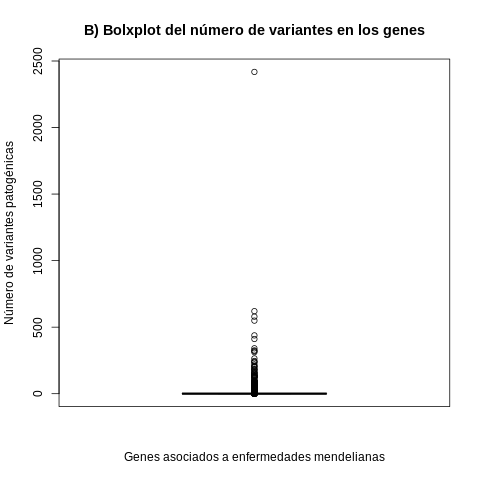

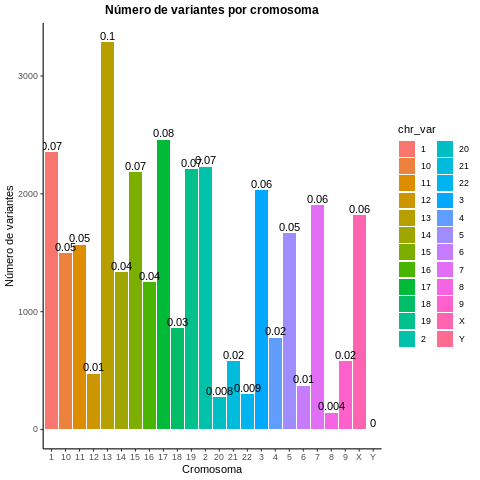

In [ ]:

%%R
library(ggplot2)

## Porcentajes de variantes de cada tipo de región
exonic_vs_intronic<-data.frame(region_type=c("Exónicas","Intrónicas"),percentage=c(89.93,10.07))
cod_vs_non_cod<-data.frame(region_type=c("Codificantes","No codificantes"),percentage=c(89.2,10.8))
genic_vs_intergenic<-data.frame(region_type=c("Génicas","Intergénicas"),percentage=c(100,0))
intronic_vs_cod_inter<-data.frame(region_type=c("Intrónicas","Codificantes","Intergénicas"),percentage=c(10.07,89.2,0))

## Porcentaje de variantes exónicas vs intrónicas 
ggplot(exonic_vs_intronic, aes(x = "", y = percentage, fill = region_type)) +
  geom_col(color = "black") +
  geom_label(aes(label = percentage),
             position = position_stack(vjust = 0.5),
             show.legend = FALSE) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c("#99CCFF", "#FFCC99"))+
  guides(fill = guide_legend(title = "Tipo de región"))+
  ggtitle("A) Porcentaje de variantes en regiones exónicas e intrónicas") +
  theme_void()+
  theme(plot.title = element_text(face="bold",  size=14, hjust = 0))

## Porcentaje de variantes génicas vs intergénicas
ggplot(genic_vs_intergenic, aes(x = "", y = percentage, fill = region_type)) +
  geom_col(color = "black") +
  geom_label(aes(label = percentage),
             position = position_stack(vjust = 0.5),
             show.legend = FALSE) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c("#FFB6C1", "#FFD700"))+
  guides(fill = guide_legend(title = "Tipo de región"))+
  ggtitle("B) Porcentaje de variantes en regiones génicas e intergénicas") +
  theme_void()+
  theme(plot.title = element_text(face="bold",  size=14, hjust = 0))


## Porcentaje de variantes codificantes vs no codificantes
ggplot(cod_vs_non_cod, aes(x = "", y = percentage, fill = region_type)) +
  geom_col(color = "black") +
  geom_label(aes(label = percentage),
             position = position_stack(vjust = 0.5),
             show.legend = FALSE) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c("#99FF33", "#FFCC00"))+
  guides(fill = guide_legend(title = "Tipo de región"))+
  ggtitle("C) Porcentaje de variantes en regiones codificantes y no codificantes") +
  theme_void()+
  theme(plot.title = element_text(face="bold",  size=14, hjust = 0))


## Porcentaje de variantes intrónicas vs codificantes vs intergénicas
ggplot(intronic_vs_cod_inter, aes(x = "", y = percentage, fill = region_type)) +
  geom_col(color = "black") +
  geom_label(aes(label = percentage),
             position = position_stack(vjust = 0.5),
             show.legend = FALSE) +
  coord_polar(theta = "y") +
  scale_fill_manual(values = c("#FF7256", "#00BFFF","#FFD700"))+
  guides(fill = guide_legend(title = "Tipo de región"))+
  ggtitle("Porcentaje de variantes en regiones intrónicas, codificantes e intergénicas") +
  theme_void()+
  theme(plot.title = element_text(face="bold",  size=14, hjust = 0))



## Distribución del número de variantes de los genes
var_per_gene<-data.frame(var_per_gene)
## Plot
ggplot(var_per_gene, aes(x=num_var, y=Freq, fill=num_var)) + 
       geom_bar(stat="identity")+
       theme_classic()+
       theme(legend.position="none")+
  ggtitle("A) Distribución del número de variantes de los genes") +
  theme(plot.title = element_text(face="bold",  size=12, hjust = 0.5))+
  xlab("Número de variantes") +
  ylab("Frecuencia")+
  coord_cartesian(xlim = c(0, 26))
## Boxplot del número de variantes en los genes
boxplot(num_var, main="B) Bolxplot del número de variantes en los genes", 
        xlab="Genes asociados a enfermedades mendelianas", ylab="Número de variantes patogénicas")


## Número de variantes por chr
var_per_chr<-data.frame(table(chr_var))
var_per_chr$chr_var<-as.character(var_per_chr$chr_var)
## Agregar chr  Y
var_per_chr[24,]<-c("Y",0)

## Plot
ggplot(var_per_chr, aes(x=chr_var, y=as.integer(Freq), fill=chr_var)) + 
       geom_bar(stat="identity")+
       theme_classic()+
       geom_text(aes(label=signif(as.integer(Freq)/32148, 1), vjust=-0.3))+
       ggtitle("Número de variantes por cromosoma") +
       theme(plot.title = element_text(face="bold",  size=12, hjust = 0.5))+
       xlab("Cromosoma") +
       ylab("Número de variantes")





In [3]:
%%R
## Reproducir código
options(width = 120)
sessioninfo::session_info()

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value
 version  R version 4.2.0 (2022-04-22)
 os       Ubuntu 18.04.5 LTS
 system   x86_64, linux-gnu
 ui       X11
 language (EN)
 collate  en_US.UTF-8
 ctype    en_US.UTF-8
 tz       Etc/UTC
 date     2022-05-15
 pandoc   1.19.2.4 @ /usr/bin/pandoc

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version date (UTC) lib source
 cli           3.3.0   2022-04-25 [2] CRAN (R 4.2.0)
 sessioninfo   1.2.2   2021-12-06 [2] CRAN (R 4.1.2)

 [1] /usr/local/lib/R/site-library
 [2] /usr/lib/R/site-library
 [3] /usr/lib/R/library

──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
